# COVID-19 Classification

Here is the PyTorch code for the COVID-19 downstream task (COVID-19 CT Grand Challenge: https://covid-ct.grand-challenge.org/)

Before you start you need to do the following: 
- Download the data from here: https://github.com/UCSD-AI4H/COVID-CT/tree/master/Images-processed 
- Download the train/val/test split of the challenge here: https://github.com/UCSD-AI4H/COVID-CT/tree/master/Data-split
- Download the Pre-Trianing Checkpoints from the GitHub README.md  

The code contains parts of: Monai (https://monai.io/), Lightning AI (https://lightning.ai/), Lightning-Hydra (https://github.com/ashleve/lightning-hydra-template)



### Preferences:

You need to fill out the first cell with your preferences:

In [2]:
# Folder where the results will be saved to: (Create a folder on your computer and type the filename here)
root_dir = "/home/wolfda/Data/Spark/Downstream/Results"

# Folder were you saved the downloaded data of the Challenge 
data_dir = "/home/wolfda/Data/Covid-Classification/Data/All" # To Folders below: CT_COVID and CT_NonCOVID

# Folder were you saved the downloaded train/val/test split of the Challenge
Covid_train = "/home/wolfda/Data/Covid-Classification/Data/COVID-CT-master/Data-split/COVID/trainCT_COVID.txt"
Covid_val = "/home/wolfda/Data/Covid-Classification/Data/COVID-CT-master/Data-split/COVID/valCT_COVID.txt"
Covid_test = "/home/wolfda/Data/Covid-Classification/Data/COVID-CT-master/Data-split/COVID/testCT_COVID.txt"
NonCovid_train = "/home/wolfda/Data/Covid-Classification/Data/COVID-CT-master/Data-split/NonCOVID/trainCT_NonCOVID.txt"
NonCovid_val = "/home/wolfda/Data/Covid-Classification/Data/COVID-CT-master/Data-split/NonCOVID/valCT_NonCOVID.txt"
NonCovid_test = "/home/wolfda/Data/Covid-Classification/Data/COVID-CT-master/Data-split/NonCOVID/testCT_NonCOVID.txt"

num_class = 2

# Choose names for Weights & Biases
Project = "Covid-19" # Name of the WandB Project
Run = "SparK_1" # Name of the Run inside the Project
wandb_tag= ["Tag"] # You can give an Tag to the Run here if you want

# Pre-Training
# Chose if you want to use a pre-trained model (Ture == Pre-Trained weights are loaded || Fales == No pre-training, model is trained from scratch)
preTrain = True 
# Type the filename to the downloaded pre-training Checkpoint here (.ckpt or .pth) [Download from Read.Me page]
pretrained_weights = "/home/wolfda/Data/Spark/Paper_Checkpoints_Upload/SparK/SparK.pth" # "/path/to/checkpoint/SparK.pth" 
# Choose the Pre-Training Method: 
pre_train = "SparK" # You can write: "SwAV" "SparK" "BYOL" "MoCo" (this must match the Checkpoint)

# Choose the model
backbone_model = "ResNet" # We have only implemeted ResNet50 -> "ResNet"

# Train Dataset Reduction: 
# What percentage of the downstream task data should be used for training? 
data_percentage = 1 # 1 for all Data; 0.5 for half the Data; ...
# Seed for Reduction
seed = 42

# Number of Epochs: 
Epochen = 70

# Learning Rate
lr = 1e-4 
WeightDecay = 0.0005 

# Batch Size
bs = 64 

# Freeze Encoder in the beginning (only the linear layer is trained) 
first_frozen = True # True: first Frozen, after n epochs open + smaller learning rate || False: Train entire encoder form Start
unfreeze = 10 # From which epoch should the encoder be open (ATTENTION: If you change the model, the encoder must be called "backbone") 


From here the Code should run without the need of changes

### Imports:

In [3]:
import os
import matplotlib.pyplot as plt
import PIL
import numpy as np

# Monai
from monai.transforms import (
    AsDiscrete,
    Compose,
    Activations,
    LoadImage,
    RandFlip,
    EnsureType,
    Resize,
)
from monai.config import print_config

# Output Metrics
from sklearn.metrics import confusion_matrix, average_precision_score, roc_auc_score, f1_score, accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score

# Weights & Biasis
from pytorch_lightning.loggers import WandbLogger
# Wandb Callbacks from hydra Template
import wandb_callbacks as wbcall
# Logger
from logging import getLogger
logger = getLogger()

# PyTorch 
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import pytorch_lightning
from pytorch_lightning import callbacks
import torchmetrics

# Random shuffle
import random

# Seed Everything 
pytorch_lightning.seed_everything(42, workers=True)

/home/wolfda/anaconda3/envs/SSL_Downstream_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-11-23 16:37:35,057 - Created a temporary directory at /tmp/tmpmc3zw19s
2023-11-23 16:37:35,058 - Writing /tmp/tmpmc3zw19s/_remote_module_non_scriptable.py
2023-11-23 16:37:35,137 - Global seed set to 42


42

### Loss + Optimizer

You can change the Loss or the Optimizer here:

In [4]:
# Loss, Optimizer 
loss = torch.nn.CrossEntropyLoss() # NLLLoss() if model already makes softmax | CrossEntropyLoss() if model already makes softmax  || Weight a class: in (): weight=torch.FloatTensor([0.3,0.7])
optim = "Adam" 
# Save informations for wandb:
info={"Path_save": root_dir, "Path_data": data_dir, "PreTrain": preTrain, "PreTrain_Weights": pretrained_weights,  "Epochs": Epochen, "first_frozen": first_frozen, "Epochs Freeze untill": unfreeze, "Learning_Rate": lr,  "Bs": bs, "Optim Weight_Decay": WeightDecay,}

### Dataset

In [5]:
##############################################################
# Read in txt
#############################################################
with open(Covid_train) as f:
    Covid_train = f.readlines()
with open(Covid_val) as f:
    Covid_val = f.readlines()
with open(Covid_test) as f:
    Covid_test = f.readlines()
with open(NonCovid_train) as f:
    NonCovid_train = f.readlines()
with open(NonCovid_val) as f:
    NonCovid_val = f.readlines()
with open(NonCovid_test) as f:
    NonCovid_test = f.readlines()

##############################################################
# Correct train/val/test split for the challenge
#############################################################
train_x = []
train_y = []
val_x = []
val_y = []
test_x = []
test_y = []

for i in range(len(Covid_train)):
    train_x.append(data_dir + "/" + Covid_train[i].split("\n")[0])
    train_y.append(0)
print("Train Covid", len(train_x))

for i in range(len(Covid_val)):
    val_x.append(data_dir + "/" + Covid_val[i].split("\n")[0])
    val_y.append(0)
print("Val Covid", len(val_x))

for i in range(len(Covid_test)):
    test_x.append(data_dir + "/" + Covid_test[i].split("\n")[0])
    test_y.append(0)
print("Test Covid", len(test_x))

for i in range(len(NonCovid_train)):
    train_x.append(data_dir + "/" + NonCovid_train[i].split("\n")[0])
    train_y.append(1)
print("Train Gesamt", len(train_x))

for i in range(len(NonCovid_val)):
    val_x.append(data_dir + "/" + NonCovid_val[i].split("\n")[0])
    val_y.append(1)
print("Val Gesamt", len(val_x))

for i in range(len(NonCovid_test)):
    test_x.append(data_dir + "/" + NonCovid_test[i].split("\n")[0])
    test_y.append(1)
print("Test Gesamt", len(test_x))

Train Covid 191
Val Covid 60
Test Covid 98
Train Gesamt 425
Val Gesamt 118
Test Gesamt 203


In [6]:
# Reduce Train Data

# Seed
np.random.seed(seed)
# Zip the two lists togethe
zipped_lists = list(zip(train_x, train_y))
# Shuffle the zipped list
random.shuffle(zipped_lists)
# Calculate the new length of the lists
new_length = int(len(zipped_lists) * data_percentage)
# Slice the zipped list to get the first half
reduced_zipped_lists = zipped_lists[:new_length]
# Unzip the reduced zipped list into two separate lists
reduced_train_x, reduced_train_y = zip(*reduced_zipped_lists)
train_x = list(reduced_train_x)
train_y = list(reduced_train_y)

print("Reduced Train X", len(train_x))
print("Reduced Train Y", len(train_y))
print("Class 0", train_y.count(0))
print("Class 1", train_y.count(1))



Reduced Train X 425
Reduced Train Y 425
Class 0 191
Class 1 234


### Data visualization (not required)

(291, 472, 3)
(439, 504, 3)
(299, 476, 3)
(108, 180, 4)
(398, 556, 4)
(232, 308, 3)
(170, 252, 3)
(291, 472, 3)
(341, 422, 3)


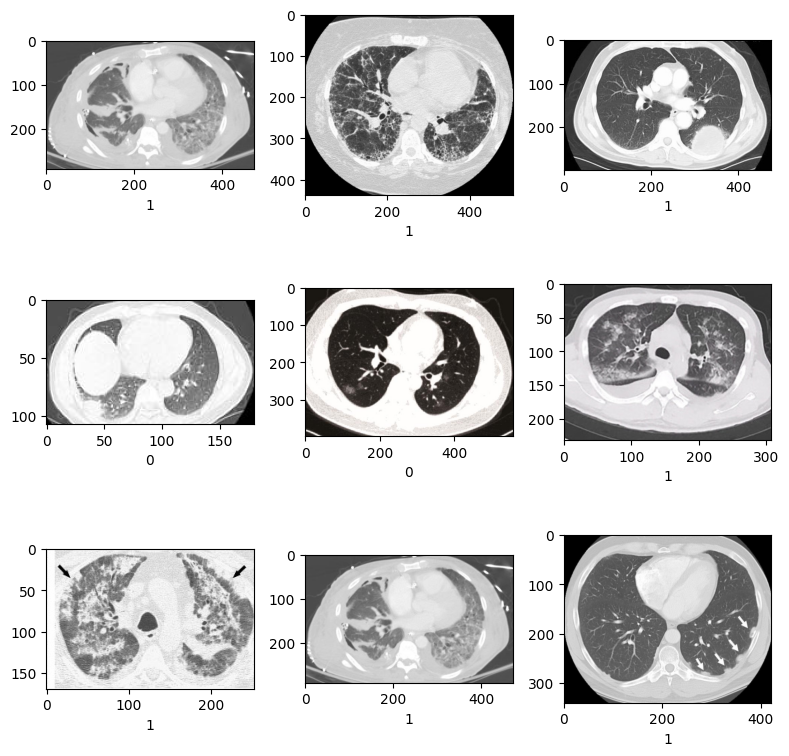

In [7]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(len(train_x), size=9)):
    im = PIL.Image.open(train_x[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(train_y[k])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
    print(arr.shape)
plt.tight_layout()
plt.show()

### Transforms

In [8]:
# Gray scale Transforms:
# If gray scale: three times the same image together -> to get 3 chaneles (Model is build for RGB (=3 Channel) image)
class gray_to_rgb(object):
    def __init__(self):
        pass
    def __call__(self, image):
        if len(image.shape) == 2: # gray
            image = np.stack((image, image, image), 2)
            return image
        if image.shape[2] == 4: # if (x,y,4) -> (x,y,3)
            image = np.stack((image[...,0], image[...,1], image[...,2]), 2)
            return image
        else:
            return image
    

In [9]:
# To uint8 (because PIL needs uint8)                               
class to_uint8(object):
    def __init__(self):
        pass
    def __call__(self, image):
        image = image.astype(np.uint8)
        return image

In [10]:
# maps values form [255,0] -> [1,0]
class scale(object):
    def __init__(self):
        pass
    def __call__(self, image):
        # map values from [from_min, from_max] to [to_min, to_max]
        # image: input array
        from_range = 255 - 0
        to_range = 1 - 0
        scaled = np.array((image - 0) / (float(from_range)+0.00001), dtype=float)
        return 0 + (scaled * to_range)

In [11]:
# Transforms

# Mean and Std of the gray scale values of the training dataset
mean = [0.5600, 0.5596, 0.5596]
std = [0.2905, 0.2907, 0.2908]

train_transforms = transforms.Compose(
    [   
        # Load Image
        LoadImage(image_only=True), # Loads Image (nii, nii.gz -> NibabelReader), (png, jpg, bmp -> PILReader), (npz, npy -> NumpyReader), (nrrd -> NrrdReader), (DICOM file -> ITKReader)
        # Numpy Array [HxWxChannels] [Range: 0-255]
        
        # If Gray scale: (x,y) -> 3x(x,y) 
        gray_to_rgb(),
        
        # To PIL -------------------------------------
        to_uint8(), # PIL needs numpy array with uint8, converts to [0-255, 8 bit]
        transforms.ToPILImage(), # numpy to PIL (Numpy Image needs to be: [HxWxChannels])
        
        # ... PIL Transforms can be added here ...
        
        # OR ----------------------------------------
        # If no PIL before: 
        # Scale [255,0] -> [1,0]
        #scale(),
        # -------------------------------------------
        
        # PIL/Numpy to Torch ------------------------
        # [HxWxChannels] -> [ChannelsxWxH]
        # If PIL before: [0-225] -> [0-1] || If numpy Numpy: [0-225] -> [0-225]
        transforms.ToTensor(),
        
        # ... Torch or Monai Transforms can be added here ... 
        
        # Normalize:
        # Needs to be: [0,1] 
        transforms.Normalize(mean=mean, std=std), # Normalize (Mean should be arround 0 now)
        
        # Resize:
        Resize(spatial_size=(224,224)), # Resize to [Channelsx224x224]
        
        #RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        
        EnsureType(), # no matter what -> to Torch (not needed here as we already have Torch)
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True),
     gray_to_rgb(),  
     
     # PILL ----------
     to_uint8(), 
     transforms.ToPILImage(), 
     
     # OR -----
     #scale(),
     
     transforms.ToTensor(), 
     transforms.Normalize(mean=mean, std=std),
     Resize(spatial_size=(224,224)),
     EnsureType(),
    ])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=num_class)])

In [12]:
# PT Dataset

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

Here we test the Transforms: 

In [13]:
example = MedNISTDataset(train_x, train_y, train_transforms)
example_Image = example.__getitem__(0)

# Numpy / Torch 
im = example_Image[0]
print(im.shape)
print(torch.max(im), torch.min(im))
print(torch.max(im[0]), torch.min(im[0]))
print(torch.max(im[1]), torch.min(im[1]))
print(torch.max(im[2]), torch.min(im[2]))

(3, 224, 224)
tensor(1.5150) tensor(-1.8535)
tensor(1.5146) tensor(-1.8535)
tensor(1.5150) tensor(-1.8508)
tensor(1.5144) tensor(-1.8502)


### Load Model and Pre-Training
Here, the ResNet50 model is loaded and initialized with the pre-training checkpoints:

#### Expected output of this Cell: 
If this appears, everything is correct: 
- missing_keys= ['fc.weight', 'fc.bias'] (beacuse the last fully connected layer was not pre-trained) 
- unexpected_keys= 
    - MoCo: All "encoder_k" layers (because MoCo has 2 encoders and we use only encoder_q)
    - BYOL: All "online_network.projector" and "target_network.encoder" layers (because BYOL has 2 encoders and we only the online_network.encoder)
    - SwAV: All "projection_head" layers (beacuse SwAV has an aditional projection head for the online clustering) 
    - SparK: []
    
    
#### You can insert a new model here:
To check the names of the model and the pre-training checkpoints, use:

    model = models.xyz()
    state_dict = torch.load(pretrained_weights)
    for k, v in model.state_dict().items():
        print(k)
    print("--------------------------------------------------------------------------------")
    for k, v in state_dict.items():
        print(k)

In [14]:
# Model-----------------------------------------------------------------------------

if backbone_model == "ResNet":
    res_model = models.resnet50() # PyTorch Torchvision Resnet50 Model
else:
    print("No Model")
    

# Pre-Training --------------------------------------------------------------------------------
if preTrain == True:
    
    
    # Load pre-training weights
    state_dict = torch.load(pretrained_weights)  #pretrained_weights
    
    # Match the correct name of the layers between pre-trained model and PyTorch ResNet
    # Extraction:
    if "module" in state_dict: # (SparK)
        state_dict = state_dict["module"] 
    if "state_dict" in state_dict: # (SwAV, MoCo, BYOL) 
        state_dict = state_dict["state_dict"]
    # Replacement:
    if pre_train == "SparK" or pre_train == "SwAV":
        state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()} 
    elif pre_train == "MoCo":
        state_dict = {k.replace("encoder_q.", ""): v for k, v in state_dict.items()} 
    elif pre_train == "BYOL":
        state_dict = {k.replace("online_network.encoder.", ""): v for k, v in state_dict.items()} 

    # Initialisation of the ResNet model with pre-training checkpoints
    msg = res_model.load_state_dict(state_dict, strict=False)
    
    
    # Check if it works
    print(format(msg))

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])


### PyTorch Lightning Class

In [15]:
class Net(pytorch_lightning.LightningModule): 
    
    def __init__(self):
        super().__init__()
        
        # Remove the last layer (linear layer) and add a own linear layer 
        # This is needed for the freezing. The Conv part that should be frozen (without the linear layer) needs to be named "backbone". 
        self.net = res_model
        
        if backbone_model == "ResNet":
            # Remove last layer 
            num_filters = self.net.fc.in_features
            layers = list(self.net.children())[:-1]
            self.backbone = torch.nn.Sequential(*layers)
            # Add one linear layer for classification
            self.classifier = torch.nn.Linear(num_filters, num_class)
            del self.net
        
        # Loss
        self.loss_function = loss 
        
        # Metrics
        self.best_acc = torchmetrics.MaxMetric()
    

    def forward(self, x):

        x = self.backbone(x).flatten(1)
        x = self.classifier(x)

        return x
    
    def on_train_start(self):
        # by default lightning executes validation step sanity checks before training starts,
        # so we need to make sure val_acc_best doesn't store accuracy from these checks
        self.best_acc.reset()


    def prepare_data(self):

        # Creates dataset (path in which all images and labels are located ([vol, class]) + transforms)
        self.train_ds = MedNISTDataset(train_x, train_y, train_transforms)
        self.val_ds = MedNISTDataset(val_x, val_y, val_transforms)
        self.test_ds = MedNISTDataset(test_x, test_y, val_transforms)
        
    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(self.train_ds, batch_size=bs, shuffle=True, num_workers=10)
        print("Train Data Loader | Bs:", bs, "| len",  len(train_loader), "| ges", bs*len(train_loader))
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(self.val_ds, batch_size=1, num_workers=10)
        print("Val Data Loader", len(val_loader))
        return val_loader
    
    def test_dataloader(self): 
        test_loader = torch.utils.data.DataLoader(self.test_ds, batch_size=1, num_workers=10)
        print("Test Data Loader", len(test_loader))
        return test_loader

    def configure_optimizers(self):
        if optim == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr, weight_decay = WeightDecay)
        return optimizer

    def training_step(self, batch, batch_idx): # batch = PT Dataset
        images, labels= batch 
        
        output = self.forward(images) 
        
        loss = self.loss_function(output, labels) 
        
        # Wandb Logs
        self.log("train/loss", loss.item())

        return {"loss": loss}
    
    def training_epoch_end(self, outputs): # outputs = Sampels in the train dataset  x {"loss": loss, "log": tensorboard_logs}
        train_loss, num_items = 0, 0
        
        for output in outputs: # Loops through all smaples in the train dataset 

            train_loss += output["loss"].sum().item() # Adds all losses
            num_items += 1
            
        mean_train_loss = torch.tensor(train_loss / num_items) # mean loss
        
        # Wandb Logs
        self.log("train/mean_loss", mean_train_loss,)
    

    def validation_step(self, batch, batch_idx): 
        images, labels= batch 
        
        outputs = self.forward(images) 
        
        klasse = torch.argmax(outputs, dim=1) # Find index with highest probability
        
        loss = self.loss_function(outputs, labels)
        
        return {"val_loss": loss, "targets": labels, "preds": klasse}
    

    def validation_epoch_end(self, outputs): # outputs = Samples in val dataset x {"val_loss": loss, "targets": labels, "preds": klasse}
        val_loss, num_items, true, false = 0, 0, 0, 0 
        
        
        for output in outputs: # Loops through all smaples in the val dataset 
            val_loss += output["val_loss"].sum().item() # Adds all losses
            num_items += 1
            
            # How many classified correctly
            if output["preds"] == output["targets"]: # if index with highest probability == correct class -> correctly classified
                true += 1
            else:
                false += 1
            
        mean_val_loss = torch.tensor(val_loss / num_items) # mean Loss
        
        # Accurancy
        acc = torch.tensor(true / num_items)
        self.best_acc.update(acc)
        best_acc = self.best_acc.compute()
        
        # Wandb Logs 
        self.log("val/loss", mean_val_loss)
        self.log("val/accuracy", acc)
        self.log("val/best_accuracy", best_acc)
        
        

    
    def test_step(self, batch, batch_idx): 
        images, labels = batch 
        
        outputs = self.forward(images) 
        outputs = torch.nn.functional.softmax(outputs)
        
        klasse = torch.argmax(outputs, dim=1)
        
        loss = self.loss_function(outputs, labels)
        
        return {"test_loss": loss, "output": outputs, "targets": labels, "preds": klasse} 
    
    
    def test_epoch_end(self, outputs): # outputs = Samples in test dataset x  {"test_loss": loss, "output": outputs, "lable": labels, "klasse": klasse}
        
        test_loss, true, false, num_items = 0, 0, 0, 0
        
        output_list = np.array([])
        lable_list = np.array([])
        output_prob = np.array([])
        
        i = 0
        for output in outputs: # Loops through all smaples in the val dataset
            
            test_loss += output["test_loss"] 
            num_items += 1
            
            output_hold = output["preds"].cpu().detach()
            lable_hold = output["targets"].cpu().detach()
            output_prob_hold = output["output"].cpu().detach()
            
            output_list = np.append(output_list, output_hold) 
            lable_list = np.append(lable_list, lable_hold) 
            output_prob = np.append(output_prob, output_prob_hold[...,1]) # Output from network: [0.4524, 0.5476] -> take only the second value = Propablility score class 0 and 1
            

            if output["preds"] == output["targets"]: 
                true += 1
            else:
                false += 1
            i+=1
            
        output_list = output_list.astype(int)
        lable_list = lable_list.astype(int)
        output_prob = output_prob
        
        
        # __________ DOKU ____________________________
        
        
         # Number correctly classified
        print("\n" + "True", true) 
        print("False", false)
        
        # Accurancy
        acc = torch.tensor(true / num_items) 
        print("\n" + "acc", acc)
        
        # AUC
        auc = roc_auc_score(lable_list, output_prob)
        print("\n" + "AUC",auc)
        
        # F1
        f1 = f1_score(lable_list, output_list)
        print("\n" + "F1",f1)
        
        # precission
        precision = precision_score(lable_list, output_list)
        print("\n" + "precision", precision)
        
        # Mean Loss
        mean_test_loss = torch.tensor(test_loss / num_items) # mittlerer Loss
        print("\n" + "mean_loss", mean_test_loss)
        
        # Confusion Matrix
        cm = confusion_matrix(lable_list, output_list)
        print("\n", cm)
        
        # Report: Precision, Recall, F-Score
        print("\n" +"Classification Report: ")
        score01 = classification_report(lable_list, output_list)
        print("\n", score01)

        # Wandb Logs
        self.log("test/Loss", mean_test_loss)
        self.log("test/Accuracy", acc)
        self.log("test/AUC", auc)
        self.log("test/F1", f1)
        self.log("test/Precision", precision)

### Train, Test, Save

In [16]:
# initialise the LightningModule
net = Net()

# Creates a path to save the checkpoints and WandB infos: 
checkpoint_dir = os.path.join(root_dir, Project, Run) 
try:
    os.makedirs(checkpoint_dir)  
except OSError:
    print ("Path %s exsists" % checkpoint_dir)
else:
    print ("Successfully created path %s" % checkpoint_dir)

    
# weights and biases
wandb_logger = WandbLogger(project=Project, name=Run, tags = wandb_tag, save_dir=checkpoint_dir)


## Callbacks  

# Saves the Checkpoints 
checkpoint_callback = callbacks.ModelCheckpoint( # opens a new folder each time (logs-"test1-{epoch}-{val_loss:.2f}") Stores the statu
    dirpath = checkpoint_dir, # Saves path
    monitor = "val/accuracy", # What I want to write in filename I have to monitor here  
    mode="max", 
    filename = "{epoch}",
    save_last = True, # Saves the status of the last epoch of training (Name: last.ckpt)
    save_top_k = 2, # Saves the status of the k=2 best epochs [best val accuracy] of the training  (Name: epoch=*-val_loss=*.ckpt)
)

# Set up to which epoch you want to freeze 
# What you want to freeze must be called "backbone"
finetuning = callbacks.BackboneFinetuning(
    unfreeze_backbone_at_epoch=unfreeze, 
    )

# Loggt Lr in Wandb
lr_monitor = callbacks.LearningRateMonitor(logging_interval=None, log_momentum=True)


# All Callbacks together  (from here and from Hydra [wbcall von wandb_callbacks.py, von hydra template])
if first_frozen == True:
    callback_summary = [checkpoint_callback, finetuning, lr_monitor, wbcall.LogConfusionMatrix(), wbcall.LogF1PrecRecHeatmap()]
else:
    callback_summary = [checkpoint_callback, lr_monitor, wbcall.LogConfusionMatrix(), wbcall.LogF1PrecRecHeatmap()]

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=1,
    max_epochs=Epochen, # Epochs
    logger=wandb_logger, # weight & biasis 
    log_every_n_steps=9, # How often does it log (every 9 steps)  
    callbacks=callback_summary,
    num_sanity_val_steps=1, # Does a run with the Val dataset to check if everything fits
)

trainer.logger.log_hyperparams(info) # So that my information is logged in wandb

# train + val
trainer.fit(net)

# test
ckpt_path = trainer.checkpoint_callback.best_model_path
print(ckpt_path)
trainer.test(net, ckpt_path=ckpt_path)

Successfully created path /home/wolfda/Data/Spark/Downstream/Results/Covid-19/SparK_3


wandb: Currently logged in as: wolfda95. Use `wandb login --relogin` to force relogin


/home/wolfda/anaconda3/envs/SSL_Downstream_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(


2023-11-23 16:37:51,883 - GPU available: True (cuda), used: True
2023-11-23 16:37:51,884 - TPU available: False, using: 0 TPU cores
2023-11-23 16:37:51,884 - IPU available: False, using: 0 IPUs
2023-11-23 16:37:51,884 - HPU available: False, using: 0 HPUs


/home/wolfda/anaconda3/envs/SSL_Downstream_2/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/wolfda/Data/Spark/Downstream/Results/Covid-19/SparK_3 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


2023-11-23 16:37:52,012 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-11-23 16:37:52,017 - 
  | Name          | Type             | Params
---------------------------------------------------
0 | backbone      | Sequential       | 23.5 M
1 | classifier    | Linear           | 4.1 K 
2 | loss_function | CrossEntropyLoss | 0     
3 | best_acc      | MaxMetric        | 0     
---------------------------------------------------
57.2 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
Sanity Checking: 0it [00:00, ?it/s]Val Data Loader 118
                                                                           

/home/wolfda/anaconda3/envs/SSL_Downstream_2/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=9). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Train Data Loader | Bs: 64 | len 7 | ges 448
Epoch 0:   6%|▌         | 7/125 [00:02<00:34,  3.41it/s, loss=0.684, v_num=xyid]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 125/125 [00:04<00:00, 26.63it/s, loss=0.684, v_num=xyid]

/home/wolfda/anaconda3/envs/SSL_Downstream_2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1:   6%|▌         | 7/125 [00:01<00:33,  3.51it/s, loss=0.671, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 2:   6%|▌         | 7/125 [00:02<00:37,  3.16it/s, loss=0.655, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 3:   6%|▌         | 7/125 [00:02<00:34,  3.39it/s, loss=0.635, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 4:   6%|▌         | 7/125 [00:02<00:36,  3.27it/s, loss=0.619, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 5:   6%|▌         | 7/125 [00:02<00:36,  3.20it/s, loss=0.607, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 6:   6%|▌         | 7/125 [00:02<00:36,  3.25it/s, loss=0.597, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 7:   6%|▌         | 7/125 [00:02<00:34,  3.42it/s, loss=0.592, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 8:   6%|▌         | 7/125 [00:02<00:35,  3.37it/s, loss=0.586, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 9:   6%|▌         | 7/125 [00:02<00:35,  3.33it/s, loss=0.583, v_num=xyid]  
Valid

/home/wolfda/anaconda3/envs/SSL_Downstream_2/lib/python3.10/site-packages/pytorch_lightning/callbacks/finetuning.py:211: UserWarning: The provided params to be frozen already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


Epoch 10:   6%|▌         | 7/125 [00:02<00:44,  2.62it/s, loss=0.548, v_num=xyid]
Validation: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████| 125/125 [00:04<00:00, 26.07it/s, loss=0.548, v_num=xyid]

/home/wolfda/PycharmProjects/SSL-MedicalImagining-CL-MAE/Downstream/wandb_callbacks.py:164: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(14, 8))


Epoch 11:   6%|▌         | 7/125 [00:02<00:39,  3.01it/s, loss=0.475, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 12:   6%|▌         | 7/125 [00:02<00:38,  3.09it/s, loss=0.386, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 13:   6%|▌         | 7/125 [00:02<00:42,  2.79it/s, loss=0.313, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 14:   6%|▌         | 7/125 [00:02<00:38,  3.08it/s, loss=0.259, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 15:   6%|▌         | 7/125 [00:02<00:39,  2.99it/s, loss=0.202, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 16:   6%|▌         | 7/125 [00:02<00:38,  3.03it/s, loss=0.152, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 17:   6%|▌         | 7/125 [00:02<00:39,  2.97it/s, loss=0.111, v_num=xyid]  
Validation: 0it [00:00, ?it/s]
Epoch 18:   6%|▌         | 7/125 [00:02<00:41,  2.84it/s, loss=0.0764, v_num=xyid] 
Validation: 0it [00:00, ?it/s]
Epoch 19:   6%|▌         | 7/125 [00:02<00:41,  2.87it/s, loss=0.0578, v_num=xyi

/home/wolfda/anaconda3/envs/SSL_Downstream_2/lib/python3.10/site-packages/torch/_tensor.py:1121: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)


Testing DataLoader 0: 100%|██████████| 203/203 [00:02<00:00, 93.28it/s]
True 140
False 63

acc tensor(0.6897)

AUC 0.8064139941690962

F1 0.7604562737642585

precision 0.6329113924050633

mean_loss tensor(0.5988, device='cuda:0')

 [[ 40  58]
 [  5 100]]

Classification Report: 

               precision    recall  f1-score   support

           0       0.89      0.41      0.56        98
           1       0.63      0.95      0.76       105

    accuracy                           0.69       203
   macro avg       0.76      0.68      0.66       203
weighted avg       0.76      0.69      0.66       203

Testing DataLoader 0: 100%|██████████| 203/203 [00:02<00:00, 90.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/AUC            0.806

/tmp/ipykernel_102850/659808598.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_test_loss = torch.tensor(test_loss / num_items) # mittlerer Loss


[{'test/Loss': 0.598846435546875,
  'test/Accuracy': 0.6896551847457886,
  'test/AUC': 0.8064139941690962,
  'test/F1': 0.7604562737642585,
  'test/Precision': 0.6329113924050633}]

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x300 with 0 Axes>

In [ ]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel